# BOINC first try
This code will read from job archive table in ES and ...

In [1]:
%matplotlib inline
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import time
from pandas.plotting import table

from elasticsearch import Elasticsearch, helpers

last_days=30
avail_cpu=456
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')

indices = sorted(indices)
indices = [x for x in indices if x != '' and not x.endswith('_reindexed')]
#print(indices)
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

ind = time_filter(indices, last_days)
print ("number of indices:", len(ind))
#print(ind)
ind = ','.join(ind)
#print(ind)
etime=int(time.time()*1000)
stime=etime-3600*24*last_days*1000
true="true"
false="false"
my_query={
  "size": 0,
  "version": true,
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "modificationhost:(/.*lwn1[2-4][0-9].ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/ )",
            "analyze_wildcard": true,
            "lowercase_expanded_terms": false
          }
        },
        {
          "range": {
            "modificationtime": {
              "gte": stime,
              "lte": etime,
              "format": "epoch_millis"
            }
          }
        }
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "terms": {
        "field": "computingsite",
        "size": 10,
        "order": {
          "_term": "desc"
        }
      },
      "aggs": {
        "3": {
          "sum": {
            "script": {
              "inline": "double max_cpu_per_event=2000;double cpusec=doc['cpuconsumptiontime'].value; String site=doc['computingsite'].value;double nevents=doc[\"nevents\"].value;if (site==\"BOINC_MCORE\" && (cpusec>max_cpu_per_event*nevents || cpusec<0)) {return max_cpu_per_event*nevents/(3600*24)} else {return cpusec/(3600*24)}",
              "lang": "painless"
            }
          }
        },
        "4": {
          "sum": {
            "script": {
              "inline": "double core=doc['actualcorecount'].value; double wall_time=doc['wall_time'].value;if (core>0) {return (wall_time * core)/(3600*24)} else {return (wall_time)/(3600*24)}",
              "lang": "painless"
            }
          }
        }
      }
    }
  },
  "_source": {
    "excludes": []
  },
  "highlight": {
    "pre_tags": [
      "@kibana-highlighted-field@"
    ],
    "post_tags": [
      "@/kibana-highlighted-field@"
    ],
    "fields": {
      "*": {
        "highlight_query": {
          "bool": {
            "must": [
              {
                "query_string": {
                  "query": "modificationhost:(/.*lwn1[2-4][0-9].ihep.ac.cn/ OR /.*lwn15[0-2].ihep.ac.cn/ )",
                  "analyze_wildcard": true,
                  "lowercase_expanded_terms": false,
                  "all_fields": true
                }
              },
              {
                "range": {
                  "modificationtime": {
                    "gte": stime,
                    "lte": etime,
                    "format": "epoch_millis"
                  }
                }
              }
            ],
            "must_not": []
          }
        }
      }
    },
    "fragment_size": 2147483647
  }
}
res = es.search(index=ind, body=my_query, request_timeout=12000)
#print(res)
site_res={}
site_res["cpu_days"]={}
site_res["wall_days"]={}
buckets=res['aggregations']['2']['buckets']
for i in range(len(buckets)):
    sitename=buckets[i]['key']
    walltime=buckets[i]["4"]['value']
    cputime=buckets[i]["3"]['value']
    print(sitename,walltime,cputime)
    #site_res[sitename]={}
    #site_res[sitename]=[cputime,walltime]
    site_res["cpu_days"][sitename]=cputime/last_days
    site_res["wall_days"][sitename]=walltime/last_days
    


print(site_res)

number of indices: 30
BOINC_MCORE 8678.901712962957 4946.949583333331
BEIJING_MCORE 4979.895277777776 3483.049861111111
BEIJING 936.0081944444439 785.7328356481476
ANALY_BEIJING 561.6693865740742 334.6630092592593
{'cpu_days': {'BOINC_MCORE': 164.89831944444438, 'ANALY_BEIJING': 11.15543364197531, 'BEIJING': 26.191094521604917, 'BEIJING_MCORE': 116.10166203703703}, 'wall_days': {'BOINC_MCORE': 289.2967237654319, 'ANALY_BEIJING': 18.722312885802474, 'BEIJING': 31.20027314814813, 'BEIJING_MCORE': 165.9965092592592}}


### now we want to find all the jobs of this taskid

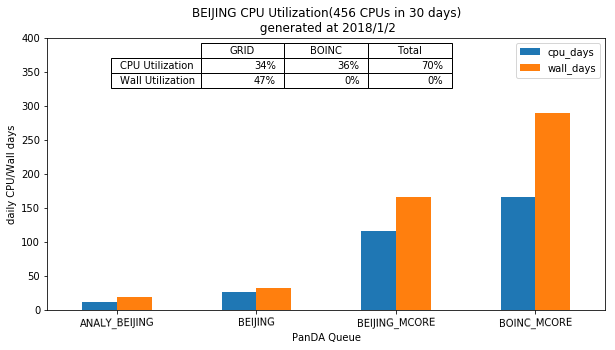

In [2]:
l=time.localtime()[0:3]
today="/".join(map(str,l))
col=site_res.keys()
df=pd.DataFrame(site_res)
#print(df)
#print(df[:3])
total_cpu=df.sum()["cpu_days"]
grid_wall=df.iloc[:3].sum()["wall_days"]
grid_cpu=df.iloc[:3].sum()["cpu_days"]
cpu_util=total_cpu/avail_cpu
grid_wall_util=grid_wall/avail_cpu
grid_cpu_util=grid_cpu/avail_cpu
boinc_cpu_util=cpu_util-grid_cpu_util
#boinc_cpu_util=df[4]["cpu_days"]/avail_cpu
#print(total_cpu, grid_wall,cpu_util,grid_wall_util,grid_cpu_util,boinc_cpu_util)
dlist=[[grid_cpu_util,boinc_cpu_util,cpu_util],[grid_wall_util,0,0]]
df2=pd.DataFrame(dlist,index=["CPU Utilization","Wall Utilization"],columns=["GRID","BOINC","Total"])
df2=df2.applymap(lambda x:"%.0f%%"%(x*100))
#print(df2)

fig, ax = plt.subplots(1, 1)
plt.title("BEIJING CPU Utilization(%d CPUs in %d days)\n generated at %s"%(avail_cpu,last_days,today))
table(ax,df2,loc="upper center",colWidths=[0.15, 0.15, 0.15])
df.plot(ax=ax,kind="bar",grid=False,figsize=(10,5),ylim=(0,400),rot=1)
ax.set_xlabel("PanDA Queue")
ax.set_ylabel("daily CPU/Wall days")

fig.savefig("beijing.png")
